# Advantage Actor-Critic


In [6]:
import sklearn.preprocessing
import numpy as np
import random
import time
import gym
import csv
import os
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch
from collections import namedtuple, deque
import random
import sys, time
import argparse
import IPython
import os.path as osp
import copy
from collections import namedtuple, deque
import random
import json

import numpy as np
import matplotlib.pyplot as plt

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(state_size, 32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.linear1.weight.data.normal_(0, 1e-1)
        self.linear2.weight.data.normal_(0, 1e-1)
        self.linear3.weight.data.normal_(0, 1e-2)
    
    def forward(self, state):
        x = state
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return torch.tanh(x)
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(state_size + action_size, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 1)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.linear1.weight.data.normal_(0, 1e-1)
        self.linear2.weight.data.normal_(0, 1e-1)
        self.linear3.weight.data.normal_(0, 1e-2)
    
    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)        
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

In [9]:
def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')

In [10]:
class Memory:
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.memory = []
        self.position = 0

    def push(self, element):
        if len(self.memory) < self.buffer_size:
            self.memory.append(None)
        self.memory[self.position] = element
        self.position = (self.position + 1) % self.buffer_size

    def sample(self):
        return list(zip(*random.sample(self.memory, self.batch_size)))

    def __len__(self):
        return len(self.memory)

In [11]:
class Agent:
    def __init__(self, state_size, action_size, buffer_size, batch_size, gamma, tau):
         # Actor Network and Target Network
        self.actor = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)

        # Critic Network and Target Network
        self.critic = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)
        
        # copy weights
        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)
        
        self.memory = Memory(buffer_size, batch_size)
        self.gamma = gamma
        self.tau = tau
        self.sd = 1
        
    def hard_update(self, target, network):
        for target_param, param in zip(target.parameters(), network.parameters()):
            target_param.data.copy_(param.data)
            
    def soft_update(self, target, network):
        for target_param, param in zip(target.parameters(), network.parameters()):
            target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)
            
    def learn(self, batch):
        
        state, action, reward, next_state, done = batch

        state = torch.tensor(state).to(device).float()
        next_state = torch.tensor(next_state).to(device).float()
        reward = torch.tensor(reward).to(device).float()
        action = torch.tensor(action).to(device)
        done = torch.tensor(done).to(device).int()
        
        # update critic
        next_action = self.actor_target(next_state)

        Q_target = self.critic_target(next_state, next_action).detach()
        Q_target = reward.unsqueeze(1) + (self.gamma*Q_target*((1-done).unsqueeze(1)))

        
        critic_loss = F.mse_loss(self.critic(state, action), Q_target)        
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # update actor
        
        action_prediction = self.actor(state)
        actor_loss = -self.critic(state, action_prediction).mean()
        
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # update actor_target and critic_target
        
        self.soft_update(self.critic_target, self.critic)
        self.soft_update(self.actor_target, self.actor)
        
    def act(self, state, noise = True):
        state =  torch.tensor(state).to(device).float()
        action = self.actor(state).cpu().data.numpy()
        
        if noise:
            noise = np.random.normal(0, self.sd)
            action = action + noise
        
        if action[0] > 1:
            action[0] = 1
        if action[0] < -1:
            action[0] = -1
        return action
    
    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))
        if len(self.memory) >= self.memory.batch_size:
            self.learn(self.memory.sample())
        
    def save(self):
        torch.save(self.actor, "mc_actor.pkl")
        torch.save(self.critic, "mc_critic.pkl")
        
    def test(self):
        new_env = gym.make("MountainCarContinuous-v0")
        new_env.seed(9)
        reward = []
        for i in range(50):
            state = new_env.reset()
            local_reward = 0
            done = False
            while not done:
                action = self.act(state, noise = False)
                state, r, done, _ = new_env.step(action)
                local_reward += r
            reward.append(local_reward)
        return reward

size of eche action = 1
size of state = 2


/tmp/ipykernel_67733/3191456121.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  state = torch.tensor(state).to(device).float()


episode: 1, current reward: -52.701844197706045
episode: 2, current reward: 58.698122612146385, max reward: -0.5315116310448817, mean reward: -0.6000314479383643
Saved
episode: 3, current reward: -49.40936085071553
episode: 4, current reward: 55.991392731826245, max reward: -39.19205403432025, mean reward: -39.611503135497884
episode: 5, current reward: -59.19627181155169
episode: 6, current reward: -56.58620682681211
episode: 7, current reward: -60.66962920152276
episode: 8, current reward: -60.029122234824065
episode: 9, current reward: -61.77279473672987
episode: 10, current reward: -61.30083514077981
episode: 11, current reward: 59.441715610564685, max reward: 66.8827112601154, mean reward: 11.728662071707172
Saved
episode: 12, current reward: 71.98739409174556, max reward: 86.97901798634445, mean reward: 40.27461374396534
Saved
episode: 13, current reward: 68.06449944100731, max reward: 88.4912981557116, mean reward: 47.97093428131089
Saved
episode: 14, current reward: 84.65706601

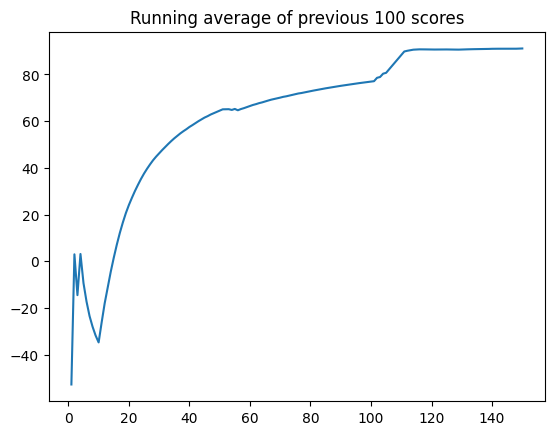

In [12]:
env = gym.make("MountainCarContinuous-v0")
np.random.seed(9)
env.seed(9)

action_size = env.action_space.shape[0]
print(f'size of eche action = {action_size}')
state_size = env.observation_space.shape[0]
print(f'size of state = {state_size}')
BUFFER_SIZE = int(1e6)  
BATCH_SIZE = 64
GAMMA = 0.99            
TAU = 1e-2                    
EPISODES = 150
def ddpg(episodes):
    agent = Agent(state_size = state_size, action_size = action_size,
              buffer_size = BUFFER_SIZE, batch_size = BATCH_SIZE,
              gamma = GAMMA, tau = TAU)
    reward_list = []
    mean_reward = -20000
    for i in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            total_reward +=reward
            state = next_state
            
        reward_list.append(total_reward)
        agent.sd = max(agent.sd - 0.01, 0.1)
        if total_reward > 50:
            r = agent.test()
            local_mean = np.mean(r)
            print(f"episode: {i+1}, current reward: {total_reward}, max reward: {np.max(r)}, mean reward: {local_mean}")
            if local_mean > mean_reward:
                mean_reward = local_mean
                agent.save()
                print("Saved")
        else:
            print(f"episode: {i+1}, current reward: {total_reward}")
            
            
    x = [i+1 for i in range(EPISODES)]
    plot_learning_curve(x, reward_list)
    return reward_list, agent

rewards, agent = ddpg(EPISODES)    

In [13]:
def show_video_of_model(agent: Agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="videos/mc_cont/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        vid.capture_frame()
        
        action = agent.act(state)

        state, reward, done, _ = env.step(action)        
    env.close()

In [14]:
# if __name__ == '__main__':
#     env = gym.make('MountainCarContinuous-v0')
    # agent = Agent(state_size = state_size, action_size = action_size,
    #           buffer_size = BUFFER_SIZE, batch_size = BATCH_SIZE,
    #           gamma = GAMMA, tau = TAU)
    # agent.load_models()
show_video_of_model(agent, 'MountainCarContinuous-v0')

    